In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Constants

In [2]:
# Global Constants
DIRECTIONS         = np.array([(0, -1), (1, 0), (0, 1), (-1, 0)])   # UP, RIGHT, DOWN, LEFT
DEFAULT_DISTANCE   = 1000
BOMB_COOLDOWN_TIME = 7
COLS = ROWS        = 17
BLAST              = np.array([-3, -2, -1, 1, 2, 3])


In [3]:
# Calculate constant BOMB_MASK one time
BOMB_MASK = np.full((COLS, ROWS, COLS, ROWS), False)

x_inside = lambda x: x > 0 and x < COLS-1
y_inside = lambda y: y > 0 and y < ROWS-1

for x in range(1, COLS-1):
        for y in range(1, ROWS-1):
            if (x % 2 == 1 or y % 2 == 1):
                explosion_spots = [(x, y)]
                if x % 2 == 1:
                    explosion_spots += [(x, y + b) for b in BLAST  if y_inside(y + b)]
                if y % 2 == 1:
                    explosion_spots += [(x + b, y) for b in BLAST  if x_inside(x + b)]
                
                explosion_spots = tuple(np.array(explosion_spots).T)
                BOMB_MASK[(x, y)][explosion_spots] \
                                = True

### Auxilliary functions to `state_to_features()`

In [4]:
def proximity_map (own_position, game_field):
    """
    calculates three values for each tile of the game field:
    1. travel time aka. distance from own position
    2. if tile is reachable from own position or blocked
    3. in which directions one can initially go to reach that tile as quick as possible

    Arguments
    ---------
    own_position : tuple (x, y)
        with x and y being current coordinates coordinates of the agent 
        on the game field. Thus 0 < x < COLS-1, 0 < y < ROWS-1.
    game_field   : np.array, shape = (COLS, ROWS)
        = game_state['field']

    Returns
    -------
    travel_time_map         : np.array, shape like game_field, dtype = int
        Reachable tiles have the value of the number of steps it takes to move to them 
        from own_position.
        Unreachable tiles have the value of DEFAULT_TRAVEL_TIME which is much higher than 
        any reachable time.
    reachable_map           : np.array, shape like game_field, dtype = bool
        A boolean mask of travel_time_map that labels reachable tiles as True and 
        unreachable ones as False.
    original_directions_map : np.array, shape = (COLS, ROWS, 4), dtype = bool
        A map of the game_field that holds a 4-element boolean array for every tile.
        Values of the tile's array correspond to the 4 directions UP, RIGHT, DOWN, LEFT 
        which you might from own_position to reach the tile. Those direction which lead you 
        to reach the tile the fastest are marked True, the others False.
        For example, if you can reach a tile the fastest by either going UP or RIGHT at the step
        then its array will look like this [TRUE, TRUE, FALSE, FALSE].
        This map will be important to quickly find the best direction towards coins, crates,
        opponents and more.
    """


    # Setup of initial values
    distance_map  = np.full_like(game_field, DEFAULT_DISTANCE)
    direction_map = np.full((*game_field.shape, 4), False)

    distance_map[own_position] = 0
    for i, dir in enumerate(DIRECTIONS):
        neighbor = tuple(dir + np.array(own_position))
        if game_field[neighbor] == 0:   # If neighbor is a free field
            direction_map[neighbor][i] = True
    

    # Breadth first search for proximity values to all reachable spots
    frontier = [own_position]
    while len(frontier) > 0:
        current = frontier.pop(0)
        
        for dir in DIRECTIONS:
            neighbor = tuple(dir + np.array(current))
            
            # Update travel time to `neighbor` field
            if game_field[neighbor] == 0:   # If neighbor is a free field
                time = distance_map[current] + 1
                if distance_map[neighbor] > time:
                    distance_map[neighbor] = time
                    frontier.append(neighbor)
                    
                    # Update original direction for `neighbor` field
                    if time > 1:
                        direction_map[neighbor] = direction_map[current]
                        
                # Combine orginial directions if travel times are equal
                elif distance_map[neighbor] == time:
                    direction_map[neighbor] = np.logical_or(
                        direction_map[neighbor], direction_map[current])


    # Derivation of reachability_map
    reachability_map = distance_map != DEFAULT_DISTANCE


    return distance_map, reachability_map, direction_map

In [5]:
def select_reachable (positions, reachability_map):
    """
    """

    if len(positions) > 0:
        positions_array     = np.array(positions)
        positions_tuple     = tuple(positions_array.T)
        reachable_mask      = reachability_map[positions_tuple]
        reachable_positions = positions_array[reachable_mask] 
    else:
        reachable_positions = np.array(positions)

    return reachable_positions

In [6]:
def select_nearest (positions, distance_map):
    """
    """

    if len(positions) > 0:
        positions_array   = np.array(positions)
        positions_tuple   = tuple(positions_array.T)
        min_distance_mask = distance_map[positions_tuple] == np.amin(distance_map[positions_tuple])
        nearest_positions = positions_array[min_distance_mask]
    else:
        nearest_positions = np.array([])    
    
    return nearest_positions

In [7]:
def make_goals (positions, direction_map, own_position):
    """
    """

    # Direction goals
    goals = np.full(5, False)
    if len(positions) > 0:
        positions_tuple  = tuple(positions.T)
        goal_directions  = direction_map[positions_tuple]
        goals[:4]        = np.any(goal_directions, axis = 0)
        
        # Check if there's a goal on the own_position
        goal_on_own_spot = (np.array(own_position) == positions).all(axis = 1).any()   # numpy-speak for "own_position in position"
        goals[4]         = goal_on_own_spot
    
    return goals

In [28]:
def crate_destruction_map (crate_map, bombs):
    """
    """

    if len(bombs) > 0:
        bomb_array       = np.array([bomb[0] for bomb in bombs])   # Bomb positions
        bomb_tuple       = tuple(bomb_array.T)
        explosion_zones  = np.any(BOMB_MASK[bomb_tuple], axis = 0)   # All fields that will be destroyed due to the current bombs.
        unexploded_zones = np.logical_not(explosion_zones)   # All fields that will be unharmed by the current bombs
    else:
        unexploded_zones = np.full_like(crate_map, True)
    
    crate_mask            = crate_map == 1   # Only show the crate positions
    crates_remaining_mask = np.logical_and(crate_mask, unexploded_zones)
    number_of_crates_destroyed_map \
                          = np.sum(np.logical_and(crates_remaining_mask, BOMB_MASK), axis = (-2, -1))
    
    return number_of_crates_destroyed_map

In [7]:
def best_crates_to_bomb (distance_map, number_of_crates_destroyed_map):
    """
    """    
    
    total_time_map        = distance_map + BOMB_COOLDOWN_TIME
    destruction_speed_map = number_of_crates_destroyed_map / total_time_map
    
    best_crates_mask = np.isclose(destruction_speed_map, np.amax(destruction_speed_map))
    best_crates      = np.array(np.where(best_crates_mask)).T
    
    return best_crates

### The CoinMiner's `state_to_features()`

In [9]:
def state_to_features (game_state):
    """
    """
    
    
    # 0. relevant game_state info
    own_position = game_state['self'][3]
    crate_map    = game_state['field']
    coins        = game_state['coins']
    bombs        = game_state['bombs']


    # 1. Check game mode
    mode = 0   #! Placeholder


    # 2. Calculate proximity map
    distance_map, reachability_map, direction_map = proximity_map(own_position, crate_map)


    # 3. Check for danger and lethal danger
    waiting_is_suicide = False   #! Placeholder
    going_is_suicide   = np.full(4, False)   #! Placeholder
    safe_directions    = np.full(4, False)   #! Placeholder
    

    # 4. Compute goal direction
    if mode == 0:
        reachable_coins = select_reachable(coins, reachability_map)
        best_coins      = select_nearest(reachable_coins, distance_map)
        goals           = make_goals(best_coins, direction_map, own_position)

    if mode == 1:
        crates_destroyed = crate_destruction_map(crate_map, bombs)
        best_crates      = best_crates_to_bomb(distance_map, crates_destroyed)
        goals            = make_goals(best_crates, direction_map, own_position)
    
    if mode == 2:
        #! Not yet implemented -> For CoinHunter
        goals = np.full(5, False)   #! Placeholder


    # 5. Assemble feature array
    features = np.full(6, 1)
    
    # Directions (f1 - f4)
    for i in range(4):
        neighbor = tuple(np.array(own_position) + DIRECTIONS[i])
        if going_is_suicide[i] or not reachability_map[neighbor]:
            features[i] = 0
        elif safe_directions[i] and goals[i]:
            features[i] = 4
        elif safe_directions[i]:
            features[i] = 2
        elif goals[i]:
            features[i] = 3

    # Own spot (f5)
    if waiting_is_suicide:
        features[4] = 0
    elif goals[4]:   # own spot is a goal
        features[4] = 2
        
    # Mode (f6)
    features[5] = mode


    return features

### Testing & prototyping

#### Test data

In [8]:
# Test crate maps
empty_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

halffull_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1,  0,  0,  0, -1],
     [-1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1],
     [-1,  1,  0,  1,  0,  1,  1,  0,  0,  1,  1,  1,  0,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1],
     [-1,  1,  0,  1,  0,  0,  0,  1,  1,  1,  0,  0,  1,  0,  1,  1, -1],
     [-1,  0, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  0,  1,  1,  0,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  0, -1,  0, -1,  0, -1,  1, -1,  0, -1],
     [-1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0, -1],
     [-1,  1, -1,  0, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  1,  0,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, -1],
     [-1,  0, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

packed_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0, -1],
     [-1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1,  0, -1],
     [-1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  0,  1,  0,  0,  1,  0, -1],
     [-1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1],
     [-1,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1],
     [-1,  1,  1,  0,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  0, -1],
     [-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0, -1],
     [-1,  1, -1,  0, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  1,  1,  0, -1],
     [-1,  0, -1,  1, -1,  0, -1,  0, -1,  0, -1,  0, -1,  1, -1,  0, -1],
     [-1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

In [9]:
# Test coin lists
coins_empty_field    = [(7, 7), (7, 8), (9, 5), (11, 3), (11, 7), (13, 5)]
coins_halffull_field = [(5, 5), (9, 5), (11, 3), (11, 7), (13, 5), (14, 1), (15, 1), (15, 7)]

In [10]:
# Test positions
positions_empty_field    = [(11, 5), (9, 7), (7, 5), (13, 9), (9, 9), (5, 7), (5, 8), (11, 7)]
positions_halffull_field = [(11, 5), (13, 7), (15, 4), (13, 2), (7, 5), (13, 8), (14, 1)]
positions_packed_field   = [(15, 1)]

In [11]:
# Expected outcomes (Outdated)
goals_empty_field   = np.array( \
    [[1, 1, 1, 1],
     [1, 1, 0, 1],
     [0, 1, 1, 0],
     [1, 0, 0, 1],
     [0, 0, 0, 1],
     [0, 1, 0, 0],
     [1, 0, 0, 0]]
)

goals_halffull_field = np.array( \
    [[1, 1, 1, 1],
     [1, 1, 0, 1],
     [1, 0, 1, 0],
     [0, 0, 1, 0],
     [0, 1, 0, 1],
     [1, 0, 0, 0]]
)

In [12]:
# Test bomb placements
bombs_none = []
bombs_some = [((11, 5), 4), ((1, 1), 2), ((7, 6), 0), ((5, 11), 1)]
bombs_many = [((11, 5), 4), ((1, 1), 2), ((7, 6), 0), ((5, 11), 1), ((5, 7), 2), ((7, 13), 3), ((15, 12), 0)]

#### Testing `crate_destruction_map()`

In [13]:
def crate_destruction_map (crate_map, bombs):  #! Testing version! Remove second return value before applying code!
    """
    """

    if len(bombs) > 0:
        bomb_array       = np.array([bomb[0] for bomb in bombs])   # Bomb positions
        bomb_tuple       = tuple(bomb_array.T)
        explosion_zones  = np.any(BOMB_MASK[bomb_tuple], axis = 0)   # All fields that will be destroyed due to the current bombs.
        unexploded_zones = np.logical_not(explosion_zones)   # All fields that will be unharmed by the current bombs
    else:
        unexploded_zones = np.full_like(crate_map, True)
    
    crate_mask            = crate_map == 1   # Only show the crate positions
    crates_remaining_mask = np.logical_and(crate_mask, unexploded_zones)
    number_of_crates_destroyed_map \
                          = np.sum(np.logical_and(crates_remaining_mask, BOMB_MASK), axis = (-2, -1))
    
    return number_of_crates_destroyed_map, crates_remaining_mask #! Latter only for testing purposes!

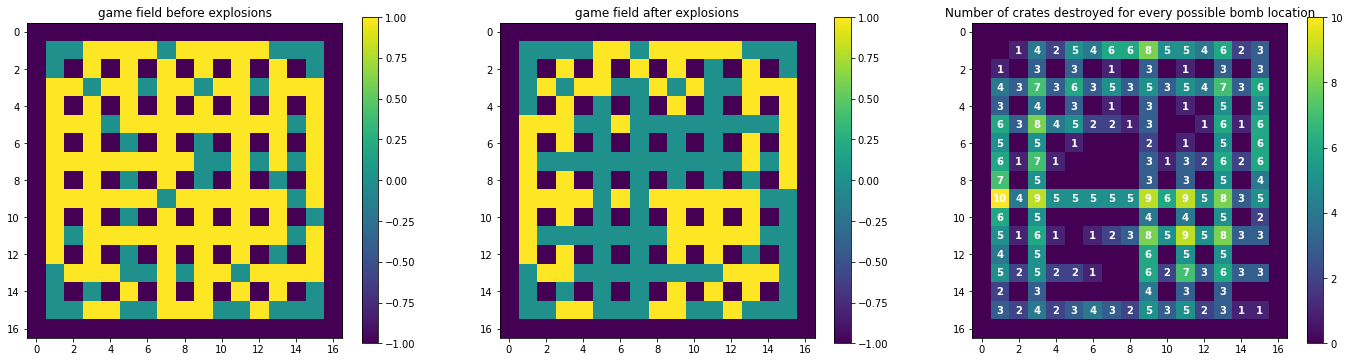

In [27]:
bombs     = bombs_many
crate_map = packed_game_field

crates_destroyed, crates_remaining_mask = crate_destruction_map(crate_map, bombs)

plt.figure(figsize=(24, 6))

# Show original crate_map
plt.subplot(1, 3, 1)

plt.imshow(crate_map.T)
plt.colorbar()
plt.title("game field before explosions")

# Show resulting crate_map (after existing bombs exploded)
plt.subplot(1, 3, 2)
crate_map_after = crates_remaining_mask + empty_game_field  # Adds walls back in
plt.imshow(crate_map_after.T)
plt.colorbar()
plt.title("game field after explosions")

# Show map of number of destroyed crates for every conceivable bomb placement.
plt.subplot(1, 3, 3)
plt.imshow(crates_destroyed.T)
plt.colorbar()
plt.title("Number of crates destroyed for every possible bomb location")

for x in range(COLS):
    for y in range(ROWS):
        if crates_destroyed[(x, y)] > 0:
            plt.text(x, y, str(crates_destroyed[(x, y)]), c = 'w', fontweight = "bold", 
                     horizontalalignment = "center", verticalalignment = "center")

plt.show()

##### `crate_destruction_map()` - Test 1

**Status:**
Testing done, performed without a flaw.

| crate_map | bombs | Result OK? |
| --- | --- | --- |
| 'empty' | 'none' | Y |
| 'halffull' | 'none' | Y |
| 'packed'   | 'none' | Y |
| 'empty' | 'some' | Y |
| 'halffull' | 'some' | Y |
| 'halffull' | 'many' | Y |
| 'packed' | 'many' | Y |

In [ ]:
array(shape(1, 2, 3, 4))
      array(sahpe(3, 4))

-> array(shape(1, 2, 3, 4))

-> array(shape(1, 2))

In [69]:
1*BOMB_MASK[(7, 9)]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Testing `make_goals()`

In [60]:
def make_goals (positions, direction_map, own_position):
    """
    """

    # Direction goals
    goals = np.full(5, False)
    if len(positions) > 0:
        positions_tuple  = tuple(positions.T)
        goal_directions  = direction_map[positions_tuple]
        goals[:4]        = np.any(goal_directions, axis = 0)
        
        # Check if there's a goal on the own_position
        goal_on_own_spot = (np.array(own_position) == positions).all(axis = 1).any()   # numpy-speak for "own_position in positions"
        goals[4]         = goal_on_own_spot
    
    return goals

[False, True, False, False]
[True,  False, False, False]

[True,  True, False, False]

[13, 7]

[[2, 9], 
 [13, 7]]

 [[False, False],
  [True,  True ]]

[False, True]

In [ ]:
[[2, 9],
 [4, 9],
 [13, 7]]

-> tuple(array.T)

[[2, 4, 13],
 [9, 9, 7]]

 (array[2, 4, 13], array[9, 9, 7])

In [66]:
# Testing select_nearest()
crate_map    = halffull_game_field
coins        = coins_empty_field
positions    = positions_halffull_field

for i, own_position in enumerate(positions):
    distance_map, reachability_map, direction_map \
                    = proximity_map(own_position, crate_map)
    reachable_coins = select_reachable(coins, reachability_map)
    best_coins      = select_nearest(reachable_coins, distance_map)
    goals           = make_goals(best_coins, direction_map, own_position)
    
    print(f"Position: {str(own_position):8},  goals: {goals}")

Position: (11, 5) ,  goals: [ True  True  True  True False]
Position: (13, 7) ,  goals: [ True False False  True False]
Position: (15, 4) ,  goals: [False False  True False False]
Position: (13, 2) ,  goals: [False False  True False False]
Position: (7, 5)  ,  goals: [False  True False False False]
Position: (13, 8) ,  goals: [ True False False False False]
Position: (14, 1) ,  goals: [False  True False False False]


##### `make_goal()` - Test 3

**Current Status:**
All issues fixed.

**Test cases:**
| coins | crate_map & positions |  Can it handle | Result | Issue |
| --- | --- | --- | --- | --- |
| 'empty' | 'empty' | normal case 1? | Yes |  |
| 'halffull' | 'halffull' | normal case 2? | Yes |  |
| [] | 'empty' | no coins? | Yes |  |
| 'empty' | 'packed' | no reachable coins? | Yes |  |
| 'empty' | 'halffull' | some unreachable coins? | Yes |  |

##### `make_goal()` - Test 2

**Test cases:**
| coins | crate_map & positions |  Can it handle | Result | Issue |
| --- | --- | --- | --- | --- |
| 'empty' | 'empty' | normal case 1? | Yes |  |
| 'halffull' | 'halffull' | normal case 2? | Yes |  |
| [] | 'empty' | no coins? | No | special case can't handle empty array |
| 'empty' | 'packed' | no reachable coins? |  |  |
| 'empty' | 'halffull' | some unreachable coins? |  |  |

##### `make_goal()` - Test 1


**Test cases:**
| coins | crate_map & positions |  Can it handle | Result | Issue |
| --- | --- | --- | --- | --- |
| 'empty' | 'empty' | normal case 1? | No | goal[4] is True when it shouldn't be |
| 'halffull' | 'halffull' | normal case 2? |  |  |
| [] | 'empty' | no coins? |  |  |
| 'empty' | 'packed' | no reachable coins? |  |  |
| 'empty' | 'halffull' | some unreachable coins? |  |  |

#### Testing `select_nearest()`

In [22]:
def select_nearest (positions, distance_map):
    """
    """

    if len(positions) > 0:
        positions_array   = np.array(positions)
        positions_tuple   = tuple(positions_array.T)
        min_distance_mask = distance_map[positions_tuple] == np.amin(distance_map[positions_tuple])
        nearest_positions = positions_array[min_distance_mask]
    else:
        nearest_positions = np.array([])    
    
    return nearest_positions

[[x1, y1],
 [x2, y2],
 ...     ]

In [23]:
# Testing select_nearest()
crate_map    = packed_game_field
coins        = coins_empty_field
positions    = positions_packed_field

for i, own_position in enumerate(positions):
    distance_map, reachability_map, _ \
                    = proximity_map(own_position, crate_map)
    reachable_coins = select_reachable(coins, reachability_map)
    best_coins      = select_nearest(reachable_coins, distance_map)
    
    print(f"Position: {str(own_position):8}")
    print(f"best_coins: \n{best_coins}\n")

Position: (15, 1) 
best_coins: 
[]



##### `select_nearest()` - Test 2

**Current Status:**
All issues fixed.

**Test cases:**
| coins | crate_map & positions |  Can it handle | Result | Issue |
| --- | --- | --- | --- | --- |
| 'empty' | 'empty' | normal case 1? | Yes |  |
| 'halffull' | 'halffull' | normal case 2? | Yes |  |
| [] | 'empty' | no coins? | Yes |  |
| 'empty' | 'packed' | no reachable coins? | Yes |  |
| 'empty' | 'halffull' | some unreachable coins? | Yes |  |

Notes:
* can also handle coins on own position

##### `select_nearest()` - Test 1 
**Test cases:**
| coins | crate_map & positions |  Can it handle | Result | Issue |
| --- | --- | --- | --- | --- |
| 'empty' | 'empty' | normal case 1? | Yes |  |
| 'halffull' | 'halffull' | normal case 2? | Yes |  |
| [] | 'empty' | no coins? | No | bug breaks function |
| 'empty' | 'packed' | no reachable coins? | No | returns all coins |
| 'empty' | 'halffull' | some unreachable coins? | Yes |  |

Notes:
* can also handle coins on own position

#### Testing `select_reachable()`

In [19]:
def select_reachable (positions, reachability_map):
    """
    """

    if len(positions) > 0:
        positions_array     = np.array(positions)
        positions_tuple     = tuple(positions_array.T)
        reachable_mask      = reachability_map[positions_tuple]
        reachable_positions = positions_array[reachable_mask] 
    else:
        reachable_positions = np.array(positions)

    return reachable_positions

In [20]:
# Testing select_reachable()
crate_map    = packed_game_field
coins        = []

_, reachability_map, _ = proximity_map((15, 1), crate_map)
reachable_coins        = select_reachable(coins, reachability_map)

print(f"All coins: {coins}")
print(f"reachable_coins: {type(reachable_coins)}\n{reachable_coins}\n")

All coins: []
reachable_coins: <class 'numpy.ndarray'>
[]



##### `select_reachable()` - Test 1

**Current Status:**
All issues fixed.

**Test cases:**
| coins | crate_map |  Can it handle | Result | Issue |
| --- | --- | --- | --- | --- |
| 'empty' | 'empty' | normal case 1? | Yes |  |
| 'halffull' | 'halffull' | normal case 2? | Yes |  |
| 'empty' | 'packed' | no reachable coins | Yes |  |
| 'halffull' | 'packed' | some reachable coins | Yes |  |
| [] | 'empty' | no coins | Yes* | Output should be array not list |

Notes:
* In this test coin positions were used but they are representative of any list of coordinates.

### To do

**To do `crate_goals`**
* Add capability to ignore bomb places where suicides are guaranteed.
* Add capability to factor in existing bombs.
* Consider time until next bomb can be placed into total_time calculation.


**Todo danger calculations**
* Talk about merging `going_is_suicide` and `waiting_is_suicide`

To do `coin_goals`

Done:
* Figure out what to do when no coins are reachable
* Does the code work if no coins are present?

Todo `make_goals()`

Done:
* Add capability for own_spot to be goal.

### Old prototype `coin_goals()`

In [38]:
def coin_goals (distance_map, direction_map, coins):
    coin_array         = np.array(coins)
    coin_tuple         = tuple(coin_array.T)
    min_distance_mask  = distance_map[coin_tuple] == np.amin(distance_map[coin_tuple])
    nearest_coins      = coin_array[min_distance_mask]
    nearest_coin_tuple = tuple(nearest_coins.T)
    coin_directions    = direction_map[nearest_coin_tuple]
    goals              = np.any(coin_directions, axis = 0)

    return goals

In [52]:
# Testing coin_goals()
crate_map    = empty_game_field
coins        = coins_empty_field
expectation  = goals_empty_field
positions    = positions_empty_field

for i, own_position in enumerate(positions):
    distance_map, reachability_map, direction_map = proximity_map(own_position, crate_map)
    goals = coin_goals(distance_map, direction_map, coins)
    print(f"Position: {str(own_position):8},  Expected: {expectation[i]},  Calculated: {goals}, " \
          f" Same: {np.all(expectation[i] == goals)}")


Position: (11, 5) ,  Expected: [1 1 1 1],  Calculated: [ True  True  True  True],  Same: True
Position: (9, 7)  ,  Expected: [1 1 0 1],  Calculated: [ True  True False  True],  Same: True
Position: (7, 5)  ,  Expected: [0 1 1 0],  Calculated: [False  True  True False],  Same: True
Position: (13, 9) ,  Expected: [1 0 0 1],  Calculated: [ True False False  True],  Same: True
Position: (9, 9)  ,  Expected: [0 0 0 1],  Calculated: [False False False  True],  Same: True
Position: (5, 7)  ,  Expected: [0 1 0 0],  Calculated: [False  True False False],  Same: True
Position: (5, 8)  ,  Expected: [1 0 0 0],  Calculated: [ True False False False],  Same: True


In [53]:
# Testing coin_goals()
crate_map    = halffull_game_field
coins        = coins_halffull_field
expectation  = goals_halffull_field
positions    = positions_halffull_field

for i, own_position in enumerate(positions):
    distance_map, reachability_map, direction_map = proximity_map(own_position, crate_map)
    goals = coin_goals(distance_map, direction_map, coins)
    print(f"Position: {str(own_position):8},  Expected: {expectation[i]},  Calculated: {goals}, " \
          f" Same: {np.all(expectation[i] == goals)}")

Position: (11, 5) ,  Expected: [1 1 1 1],  Calculated: [ True  True  True  True],  Same: True
Position: (13, 7) ,  Expected: [1 1 0 1],  Calculated: [ True  True False  True],  Same: True
Position: (15, 4) ,  Expected: [1 0 1 0],  Calculated: [ True False  True False],  Same: True
Position: (13, 2) ,  Expected: [0 0 1 0],  Calculated: [False False  True False],  Same: True
Position: (7, 5)  ,  Expected: [0 1 0 1],  Calculated: [False  True False  True],  Same: True
Position: (13, 8) ,  Expected: [1 0 0 0],  Calculated: [ True False False False],  Same: True


In [36]:
# Example data for coin goals prototype
own_position = positions_empty_field[0]
crate_map    = empty_game_field
coins        = coins_empty_field

distance_map, reachability_map, direction_map = proximity_map(own_position, crate_map)

In [37]:
# Prototyping coin goals

coin_array         = np.array(coins)
coin_tuple         = tuple(coin_array.T)
min_distance_mask  = distance_map[coin_tuple] == np.amin(distance_map[coin_tuple])
nearest_coins      = coin_array[min_distance_mask]
nearest_coin_tuple = tuple(nearest_coins.T)
coin_directions    = direction_map[nearest_coin_tuple]
goals              = np.any(coin_directions, axis = 0)

print(goals)
print(coin_directions)
print(nearest_coin_tuple)
print(nearest_coins)
print(min_distance_mask)
print(np.amin(distance_map[coin_tuple]))
print(distance_map[coin_tuple])
print(coin_tuple)
print(coin_array)

[ True  True  True  True]
[[False False False  True]
 [ True False False False]
 [False False  True False]
 [False  True False False]]
(array([ 9, 11, 11, 13]), array([5, 3, 7, 5]))
[[ 9  5]
 [11  3]
 [11  7]
 [13  5]]
[False False  True  True  True  True]
2
[6 7 2 2 2 2]
(array([ 7,  7,  9, 11, 11, 13]), array([7, 8, 5, 3, 7, 5]))
[[ 7  7]
 [ 7  8]
 [ 9  5]
 [11  3]
 [11  7]
 [13  5]]
